Started Reading data from file .. CMVOLT_25062019 (2).CSV
Old daily report file..  DailyVolatalityReport01072019_104832.xlsx  backup completed..
Started Reading data from file .. ind_nifty100list (8).csv
Completed Consolidating and Generated Report  DailyVolatalityReport01072019_124011.xlsx  Sucessfully....


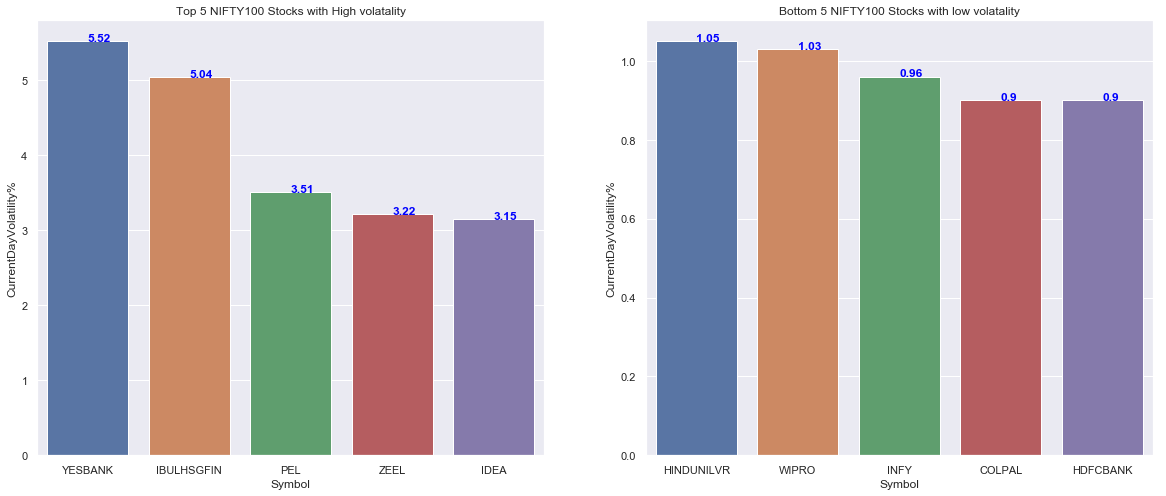

In [2]:
#!pip install ploty_express
#import plotly_express as px

import pandas as pd
import numpy as np
import math as mathObj
from datetime import datetime
import shutil
import os as osObj

import matplotlib.pyplot as plt                                    # Plotting library for Python programming language and it's numerical mathematics extension NumPy
import seaborn as sns                                              # Provides a high level interface for drawing attractive and informative statistical graphics
%matplotlib inline
sns.set()
from subprocess import check_output

def ReadNiftyDataAndPrepareReport(pd, mathObj,Datafilename=''):
    '''
    Read the Data from CSV file
    '''
    #print("Reading",Datafilename)
    # Load spreadsheet
    df_csvData = pd.read_csv(Datafilename)
    #print("Reading completed",Datafilename)
    
    # iterating the columns 
    for col in df_csvData.columns: 
        #Process the Daily Volatility (CSV)
        #Rename column anmes wich are long
        if col in 'Underlying Close Price (A)':
            df_csvData = df_csvData.rename(columns = {col:"ClosePrice"}) 
        elif col in 'Underlying Previous Day Close Price (B)':
            df_csvData = df_csvData.rename(columns = {col:"PrevDayClosePrice"}) 
        elif col in 'Underlying Log Returns (C) = LN(A/B)':
            df_csvData = df_csvData.rename(columns = {col:"LogReturns"})
        elif col in 'Previous Day Underlying Volatility (D)':
            df_csvData = df_csvData.rename(columns = {col:"PrevDayVolatility"})
        elif col in 'Current Day Underlying Daily Volatility (E) = Sqrt(0.94*D*D + 0.06*C*C)':
            df_csvData = df_csvData.rename(columns = {col:"CurrentDayVolatility"})
            #df_csvData.CurrentDayVolatility = df_csvData.CurrentDayVolatility.astype(float)
            df_csvData.CurrentDayVolatility =pd.to_numeric(df_csvData['CurrentDayVolatility'], errors='coerce')
            #print(df_csvData.CurrentDayVolatility.dtype)
            
            #Add percentage to Daily Valatility and Annual Volatality
            df_csvData['CurrentDayVolatility%']  = df_csvData.apply(lambda row: row.CurrentDayVolatility * 100, axis = 1) 
        elif col in 'Underlying Annualised Volatility (F) = E*Sqrt(365)':
            df_csvData = df_csvData.rename(columns = {col:"AnnualVolatility"})
            df_csvData.AnnualVolatility =pd.to_numeric(df_csvData['AnnualVolatility'], errors='coerce')
            #print(df_csvData.AnnualVolatility.dtype)
            
            #Add percentage to Daily Valatility and Annual Volatality
            df_csvData['AnnualVolatility%'] = df_csvData['AnnualVolatility']*100
            
        #Process the List of NIFTY 100 stocks (.csv)
        #Rename column anmes wich are long
        if col in 'ISIN Code':
            #Add a new column to show its Nifty100 Stock
            df_csvData['Nifty100'] = "Yes"
            
    return df_csvData

#Get the path of the Daily Volatility (CSV) and List of NIFTY 100 stocks (.csv)
osObj.getcwd()  #get the current working director (keep both the above files in the current working directory)
myListofFiles = []
myListofFiles = osObj.listdir(osObj.getcwd()) #Get all the files and directories
myListofFiles.sort(reverse=False)

blnNiftyCSVFound = blnDailyVolatilityCSVFound = False

    
for file in myListofFiles:
    
    if file[-3:] == "csv" or file[-3:] == "CSV": #Read only the csv extensions and ignore directories 
        print("Started Reading data from file ..",file)
        MyDatafilePath = osObj.path.join(osObj.getcwd(), file)
        dfReportData = ReadNiftyDataAndPrepareReport(pd,mathObj,MyDatafilePath)
        RepColNames = list(dfReportData.columns.values.tolist()) 
        if ('CurrentDayVolatility' in RepColNames):
            #Store this data in Volatality pd
            dfVolData = dfReportData[['Symbol','CurrentDayVolatility%','AnnualVolatility%']].copy()
            #print(dfVolData)
            blnDailyVolatilityCSVFound =True
        elif ('ISIN Code' in RepColNames):
            #Store this data in Volatality pd
            dfNifty100Data = dfReportData[['Symbol','Nifty100']].copy()
            #print(dfNifty100Data)
            blnNiftyCSVFound = True
    elif file[-4:] == "xlsx" or file[-3:] == "xls": 
        #Check if any Daily Report already exists if yes then move that to backup folder
        if ('DailyVolatalityReport' in file):
            #Move the files to BackUpFolder
            if osObj.path.exists('BackUpData-DailyVolatility') :
                #Move the file to backupdata
                MyDatafilePath = osObj.path.join(osObj.getcwd(),'BackUpData-DailyVolatility')
                shutil.move(file,MyDatafilePath)
            else:
                #create the folder and move the file
                osObj.mkdir('BackUpData-DailyVolatility')
                MyDatafilePath = osObj.path.join(osObj.getcwd(),'BackUpData-DailyVolatility')
                shutil.move(file,MyDatafilePath)   
        print("Old daily report file.. ",file," backup completed..")

#Now perform the join and publish the data in a new file called DailyVolatality Report
if blnNiftyCSVFound == True and blnDailyVolatilityCSVFound == True :
    
    dfFinalReport = pd.merge(dfVolData,dfNifty100Data,how='inner',on='Symbol')
    dfFinalReport = dfFinalReport.filter(items=['Symbol','Nifty100','CurrentDayVolatility%','AnnualVolatility%'])
    dfFinalReport = dfFinalReport.sort_values(by=['CurrentDayVolatility%'],ascending=[False])
    dfFinalReport = dfFinalReport.reset_index(drop=True)
    
    now = datetime.now()
    # dd/mm/YY H:M:S
    #DateTime = now.strftime("%d/%m/%Y %H:%M:%S")
    DateTime = now.strftime("%d%m%Y_%H%M%S")
    FinalReportExcelFileName ='DailyVolatalityReport' + DateTime + '.xlsx'

    #print(FinalReportExcelFileName)
    dfFinalReport.to_excel(FinalReportExcelFileName, engine='xlsxwriter')
    print("Completed Consolidating and Generated Report ", FinalReportExcelFileName," Sucessfully....")   

    #*************Generate Top 5 and Bottom 5 Stock List based on Daily Volatality*************************
    #Top 5 Stocks with low volatality
    #dfFinalReport.head().plot.bar()
    # Initialize Figure and Axes object
    #fig, ax = plt.subplots(figsize=(10,4))
    fig, ax = plt.subplots(1,2,figsize=(20,8))

    # Set title
    ax[0].set_title('Top 5 NIFTY100 Stocks with High volatality')
    dfTop5Group = dfFinalReport.head(5)
    ax[0] = sns.barplot( x="Symbol", y="CurrentDayVolatility%", data=dfTop5Group,ax=ax[0])
    for i, v in enumerate(dfTop5Group["CurrentDayVolatility%"]):
        ax[0].text(i , v , str(round(v,2)), color='blue', fontweight='bold')
        
    #px.bar(dfFinalReport.head(5), x="Symbol", y="CurrentDayVolatility%", barmode="group",title='Top 5 Stocks with High volatality')
    
    #Bottom 5 Stocks with Low volatality
    #px.bar(dfFinalReport.tail(5), x="Symbol", y="CurrentDayVolatility%", barmode="group",title='Bottom 5 Stocks with low volatality')
    # Set title
    ax[1].set_title('Bottom 5 NIFTY100 Stocks with low volatality')
    dfBottom5Group = dfFinalReport.tail(5)
    ax[1] = sns.barplot( x="Symbol", y="CurrentDayVolatility%", data=dfBottom5Group,ax=ax[1])
    for i, v in enumerate(dfBottom5Group["CurrentDayVolatility%"]):
        ax[1].text(i , v , str(round(v,2)), color='blue', fontweight='bold')
     
    #*************Generate Top 5 and Bottom 5 Stock List based on Daily Volatality*************************
else:
    if blnNiftyCSVFound == False :
        print("DID NOT FIND NIFTY100 CSV FILE...HENCE CANNOT GENERATE THE REPORT")
        print("Please download the NIFTY100 file from https://www.nseindia.com/content/indices/ind_nifty100list.csv")
    elif blnDailyVolatilityCSVFound == False:
        print("DID NOT FIND DAILY VOLATILITY CSV FILE...HENCE CANNOT GENERATE THE REPORT")
        print("Please download the file from https://www.nseindia.com/archives/nsccl/volt/CMVOLT_25062019.CSV")
    elif blnNiftyCSVFound == False and blnDailyVolatilityCSVFound == False:
        print("DID NOT FIND NIFTY100 and DAILY VOLATILITY CSV FILES...HENCE CANNOT GENERATE THE REPORT")
        print("Please download the DAILY VOLATILITY CSV file from https://www.nseindia.com/archives/nsccl/volt/CMVOLT_25062019.CSV")
        print("Please download the NIFTY100 file from https://www.nseindia.com/content/indices/ind_nifty100list.csv")